In [1]:
import sys, os

os.chdir("../")
sys.path.append("./../src/data")
sys.path.append("./../src/events")
sys.path.append("./../src/probability")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from IC.importer import get_IC_data, get_flux_factor
from IC.processer import bin_flux_factors
from IC.event_processing import normalize_bin_by_bin, count_plots, list_of_params
from functions import perform_chisq, ic_params
from scipy.stats import chi2
import pickle
from src.plotter import savethesis

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100
matplotlib.rc("text", usetex=True)
matplotlib.rc("text.latex", preamble=r"\usepackage{amsmath, siunitx}")
np.set_printoptions(linewidth=200)

IC_observed_full = np.array(get_IC_data().T)
E_rate, z_rate = get_flux_factor()
flux_E_factors_full, flux_z_factors_full = bin_flux_factors(E_rate, z_rate)
EFrom, ETo, zFrom, zTo = 0, 13, 0, 20
z_bins = np.arange(zFrom, zTo)
E_bins, z_bins_T = np.arange(EFrom, ETo), np.arange(zFrom, zTo)[:, None]
n_Ebins, n_zbins = len(E_bins), len(z_bins)
flux_E_factors = flux_E_factors_full[E_bins]
flux_z_factors = flux_z_factors_full[z_bins]
flux_factors = np.outer(flux_E_factors, flux_z_factors)
IC_observed = IC_observed_full[E_bins, z_bins_T].T
# IC_observed_2017 = np.array(pd.read_csv('../pre_computed/IC_observed_2017.csv', header=None))

In [2]:
giunti_contour_cl90 = pd.read_csv(
    "../src/data/files/giunti_cl90.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
IC_contour_cl90 = pd.read_csv(
    "../src/data/files/ic_24_cl90.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
# IC_contour_cl90 = pd.read_csv('../src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv(
    "../src/data/files/giunti_cl99.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
IC_contour_cl99 = pd.read_csv(
    "../src/data/files/ic_cl99.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")

E_ratios_full = pd.read_csv(
    "../src/data/files/E_ratios.csv", header=None, names=["Ereco", "Eratio"]
).Eratio.values
z_ratios_full = pd.read_csv(
    "../src/data/files/z_ratios.csv", header=None, names=["zreco", "zratio"]
).zratio.values
IC_per_z_full = np.array(np.sum(IC_observed_full, axis=0))
IC_per_E_full = np.array(np.sum(IC_observed_full, axis=1))
MC_per_E_full = IC_per_E_full / E_ratios_full
MC_per_z_full = IC_per_z_full / z_ratios_full

MC_ratios_full = np.outer(E_ratios_full, z_ratios_full)
IC_MC_full = IC_observed_full / MC_ratios_full
IC_MC = IC_MC_full[EFrom : ETo + 1, z_bins]
# IC_MC_2017 = np.load('../pre_computed/IC_MC.npy')[E_bins,z_bins_T].T #Dont use this

Ereco_full = 500 * 10 ** np.linspace(0.0, 1.3, 14)
Ereco_full_midpoints = Ereco_full[0:-1] + np.diff(Ereco_full) / 2  # For scatter plot

Ereco = Ereco_full[EFrom : ETo + 1]
Ereco_midpoints = Ereco_full_midpoints[0:14]

zreco_full = np.linspace(-1, 0, 21)
zreco_full_midpoints = zreco_full[0:-1] + np.diff(zreco_full) / 2  # For scatter plot

zreco = zreco_full[zFrom : zTo + 1]
zreco_midpoints = zreco_full_midpoints[z_bins]

In [3]:
ndim = 4
N = 17
alpha = 0.99
dm41From = 0.01
dm41To = 10
dm41N = 20
s24From = 0.01
s24To = 1
s24N = 20
dm41_range = np.logspace(np.log10(dm41From), np.log10(dm41To), dm41N)
s24_range = np.linspace(s24From, s24To, s24N)
param_list = list_of_params(ic_params, dm41_range, s24_range, s24_eq_s34=False)
print(dm41_range)
print(s24_range)

[ 0.01   0.014  0.021  0.03   0.043  0.062  0.089  0.127  0.183  0.264  0.379  0.546  0.785  1.129  1.624  2.336  3.36   4.833  6.952 10.   ]
[0.01  0.062 0.114 0.166 0.218 0.271 0.323 0.375 0.427 0.479 0.531 0.583 0.635 0.687 0.739 0.792 0.844 0.896 0.948 1.   ]


In [4]:
H1_events_list = pickle.load(
    open(f"../pre_computed/H1_IC_N{N}_{len(dm41_range)}x{len(s24_range)}.p", "rb")
)
H0_events = pickle.load(
    open(f"../pre_computed/H0_IC_N{N}.p", "rb")
)  # pickle.load(open(f'../pre_computed/H0_IC_N{N}_new.p','rb'))

In [5]:
gamma = 0.3
delta_T = 0  # (np.sum(sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma])) - np.sum(H0_events))/np.sum(H0_events)

In [6]:
norm_factors = normalize_bin_by_bin(H0_events[:, z_bins], MC=True)
H0_normalized = norm_factors * H0_events[:, z_bins]
H1_list_normalized = [norm_factors * H1[:, z_bins] for H1 in H1_events_list]

In [7]:
H1_list_normalized[0].shape, IC_observed.shape

((13, 20), (13, 20))

In [32]:
s24_cl90_index_list = []
s24_cl99_index_list = []
dm41_cl90_index_list = []
dm41_cl99_index_list = []
x0 = [1.0, 0.0]

sigma_a = 0.25
sigma_b = 0.04
sigma_g = delta_T
f = 0.2
sigma_syst = f * IC_observed

chisq_H1_list = np.array(
    [
        perform_chisq(
            H1_norm,
            IC_observed,
            sigma_syst=sigma_syst,
            z=zreco,
            sigma_a=sigma_a,
            sigma_b=sigma_b,
            sigma_g=sigma_g,
            x0=x0,
        )[0]
        for H1_norm in H1_list_normalized
    ]
)
delta_chi = chisq_H1_list - np.min(chisq_H1_list)

best_fit_index = np.argmin(delta_chi)
best_fit_params = param_list[best_fit_index]
best_fit_events = H1_list_normalized[best_fit_index]
_, best_a = perform_chisq(
    H1_list_normalized[best_fit_index],
    IC_observed,
    sigma_syst=sigma_syst,
    z=zreco,
    sigma_a=sigma_a,
    sigma_b=sigma_b,
    sigma_g=sigma_g,
    x0=x0,
)
p_value = chi2.sf(np.min(chisq_H1_list), 2)

if len(best_a) == 2:
    a = best_a[0]
    b = best_a[1]
    H1_best = a * (1 + b * (0.5 + zreco[0:-1])) * best_fit_events
elif len(best_a) == 1:
    H1_best = best_a * best_fit_events


deltachi_reshaped = delta_chi.reshape(len(dm41_range), len(s24_range))
from scipy.interpolate import RectBivariateSpline

dm41_fine = np.logspace(np.log10(dm41From), np.log10(dm41To), 49)
s24_fine = np.linspace(s24From, s24To, 49)

spl = RectBivariateSpline(s24_range, dm41_range, deltachi_reshaped)


z = spl(s24_fine, dm41_fine)
print(best_fit_params, p_value)
if f <= 0.2:
    z_small = z
    f_small = f

elif f > 0.21:
    z_big = z
    f_big = f

{'theta_12': 0.5837630475986898, 'theta_13': 0.15494769630192953, 'theta_23': 0.7695841386786632, 'theta_34': 0, 'theta_24': 0.6702501355219319, 'theta_14': 0, 'delta_ij': 3.4033920413889422, 'dm_21': 7.53e-05, 'dm_31': 0.0025153, 'dm_41': 0.01} 0.3340219523235457


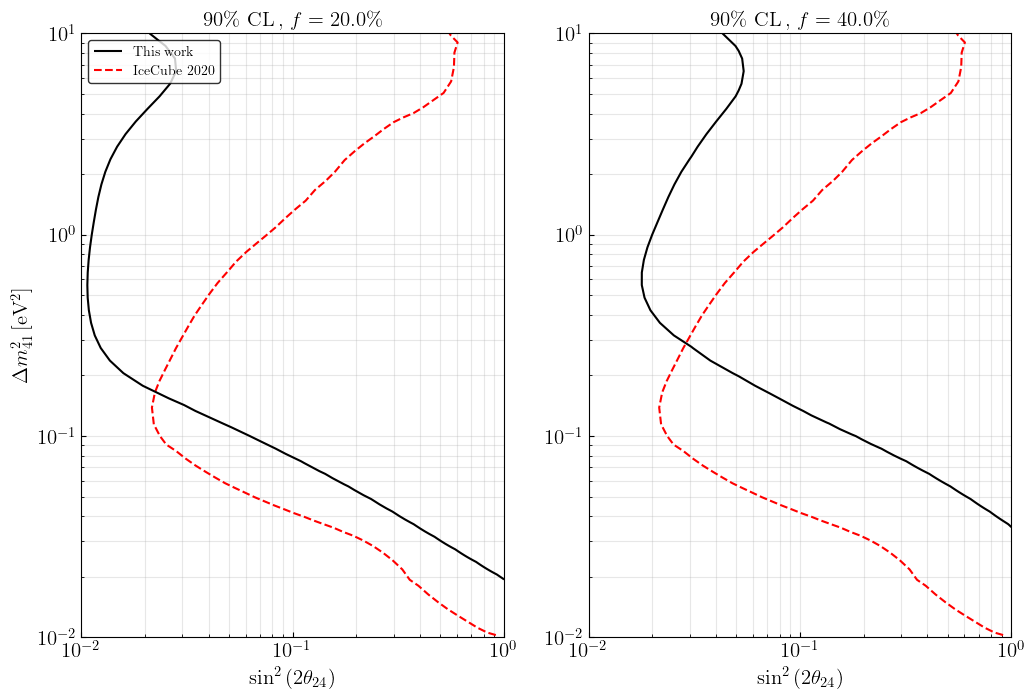

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
# ax = [ax]
# b= ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label=r'Giunti et al.')
a = ax[0].plot(
    IC_contour_cl90.s24, IC_contour_cl90.dm41, label="IceCube", c="red", ls="--"
)
# ax[0].plot(s24_range[s24_cl90_index_list], dm41_range[dm41_cl90_index_list[0]], label='Norm')
# cnt = ax[0].contour(s24_range, np.flip(dm41_range), deltachi_reshaped, levels=[chi2.cdf(0.9,2)], colors=['blue'])
cnt1 = ax[0].contour(
    s24_fine, dm41_fine, z_small, levels=[chi2.cdf(0.9, 2)], colors=["k"]
)

# ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al.',ls='solid')
ax[1].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label="IceCube", c="red", ls="--")
# ax[1].contour(s24_range, np.flip(dm41_range), deltachi_reshaped, levels=[chi2.cdf(0.99,2)], colors=['blue'])
cnt2 = ax[1].contour(
    s24_fine, dm41_fine, z_big, levels=[chi2.cdf(0.9, 2)], colors=["k"]
)
# ax[1].plot(s24_range[s24_cl99_index_list[0]], dm41_range[dm41_cl99_index_list[0]], label='Norm')


ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
# ax[0].set_xlim((5e-3, 1))
# ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-2, 1e1))
ax[1].set_ylim((1e-2, 1e1))
ax[0].set_xlabel(r"$\sin^2{(2\theta_{24})}$", fontsize=15)
ax[1].set_xlabel(r"$\sin^2{(2\theta_{24})}$", fontsize=15)
ax[0].set_ylabel(r"$\Delta m^2_{41} \, [\si{\eV\squared}]$", fontsize=15)
ax[0].grid(True, which="both", alpha=0.3)
ax[1].grid(True, which="both", alpha=0.3)
ax[0].set_title(rf"$90\%$ $\mathrm{{CL}}\,,$ $f={f_small*100}\%$", fontsize=15)
ax[1].set_title(rf"$90\%$ $\mathrm{{CL}}\,,$ $f={f_big*100}\%$", fontsize=15)
# ax[1].set_title(r'$99\%$ $\mathrm{CL}$', fontsize=15)


ax[0].tick_params(axis="both", direction="in", which="both", labelsize=15)
ax[1].tick_params(axis="both", direction="in", which="both", labelsize=15)

h1, _ = cnt1.legend_elements()
leg = ax[0].legend([h1[0], a[0]], ["This work", "IceCube 2020"])
leg.get_frame().set_edgecolor("k")
# savethesis(fig, 's24_error_tuning')

In [63]:
s24_range

array([0.01 , 0.062, 0.114, 0.166, 0.218, 0.271, 0.323, 0.375, 0.427, 0.479, 0.531, 0.583, 0.635, 0.687, 0.739, 0.792, 0.844, 0.896, 0.948, 1.   ])

In [24]:
best_fit_index = np.argmin(delta_chi.T)
best_fit_params = param_list[best_fit_index]

In [40]:
(
    best_fit_params["dm_41"],
    np.sin(2 * best_fit_params["theta_24"]) ** 2,
    best_fit_params["theta_24"],
    p_value,
)

(0.01, 0.9478947368421055, 0.6702501355219319, 0.3340219523235457)

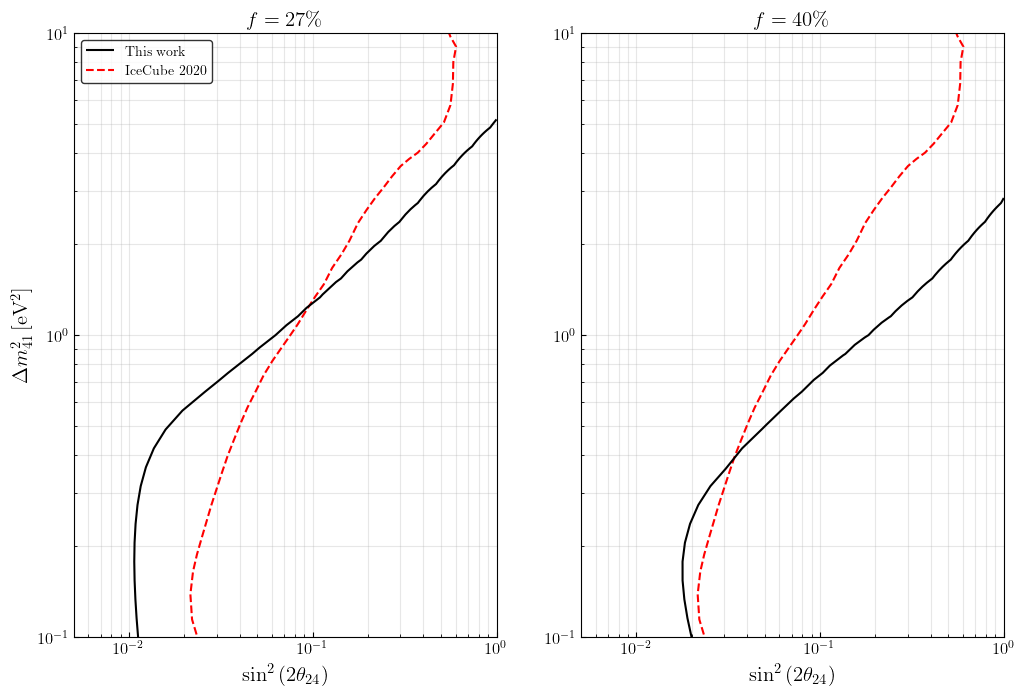

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

a = ax[0].plot(
    IC_contour_cl90.s24, IC_contour_cl90.dm41, label="IceCube", c="red", ls="--"
)
cnt = ax[0].contour(
    s24_fine, np.flip(dm41_fine), z_small, levels=[chi2.cdf(0.9, 2)], colors=["k"]
)


a = ax[1].plot(
    IC_contour_cl90.s24, IC_contour_cl90.dm41, label="IceCube", c="red", ls="--"
)
ax[1].contour(
    s24_fine, np.flip(dm41_fine), z_big, levels=[chi2.cdf(0.9, 2)], colors=["k"]
)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1, 1e1))
ax[1].set_ylim((1e-1, 1e1))
ax[0].set_xlabel(r"$\sin^2{(2\theta_{24})}$", fontsize=15)
ax[1].set_xlabel(r"$\sin^2{(2\theta_{24})}$", fontsize=15)
ax[0].set_ylabel(r"$\Delta m^2_{41} \, [\si{\eV\squared}]$", fontsize=15)
ax[0].grid(True, which="both", alpha=0.3)
ax[1].grid(True, which="both", alpha=0.3)
ax[0].set_title(r"$f = 27\%$", fontsize=15)
ax[1].set_title(r"$f = 40\%$", fontsize=15)


ax[0].tick_params(axis="both", direction="in", which="both", labelsize=12)
ax[1].tick_params(axis="both", direction="in", which="both", labelsize=12)

h1, _ = cnt.legend_elements()
leg = ax[0].legend([h1[0], a[0]], ["This work", "IceCube 2020"])
leg.get_frame().set_edgecolor("k")
# savethesis(fig, 's24_error_tuning')

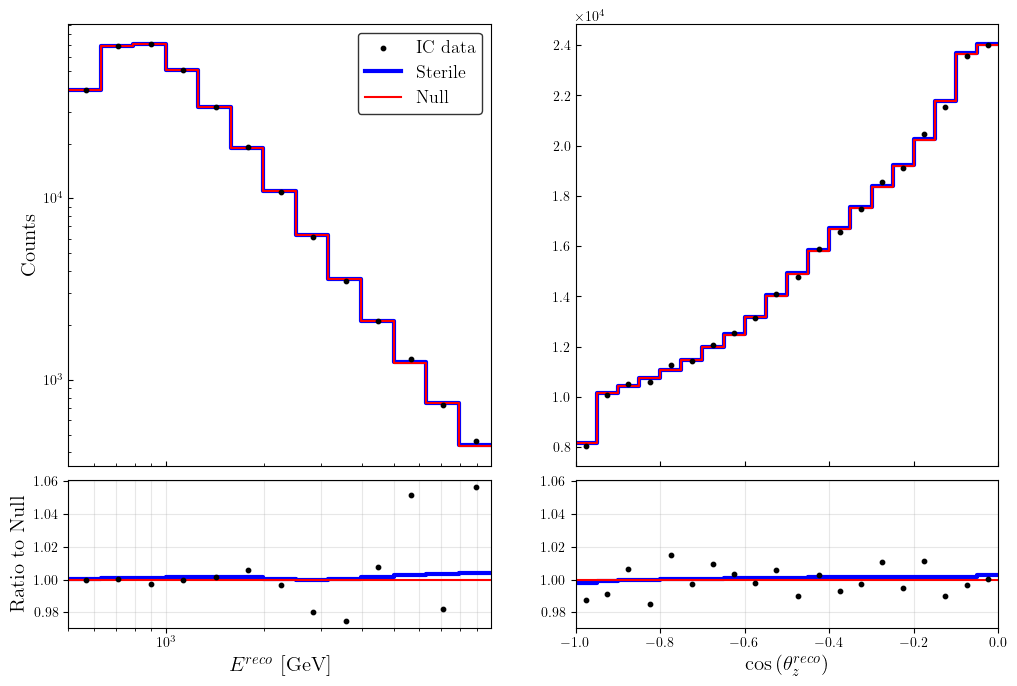

In [39]:
from IC.event_processing import count_plots

fig = count_plots(H1_best, H0_normalized)
savethesis(fig, "final_rate_plot")

In [104]:
param_list[220]

{'theta_12': 0.5837630475986898,
 'theta_13': 0.15494769630192953,
 'theta_23': 0.7695841386786632,
 'theta_34': 0,
 'theta_24': 0.7853981633974483,
 'theta_14': 0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.53e-05,
 'dm_31': 0.0025153,
 'dm_41': 1.3894954943731375}

In [136]:
param_list[70]

{'theta_12': 0.5837630475986898,
 'theta_13': 0.15494769630192953,
 'theta_23': 0.7695841386786632,
 'theta_34': 0,
 'theta_24': 0.2859096167030563,
 'theta_14': 0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.53e-05,
 'dm_31': 0.0025153,
 'dm_41': 1.3894954943731375}

In [137]:
# Plots for Smirnov 2013
from src.plotter import P_over_E_parameter

null_params = ic_params.copy()
null_params["dm_41"] = 0.0
null_params["theta_24"] = 0.0
temp_params = [null_params, param_list[70]]
Pam = P_over_E_parameter(
    "m",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
)
Pm = P_over_E_parameter(
    "m",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
)
Pe = P_over_E_parameter(
    "e",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
)
Pae = P_over_E_parameter(
    "e",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
)

Pt = P_over_E_parameter(
    "t",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
)
Pat = P_over_E_parameter(
    "t",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
)

Pamam = Pam[:, 1]
Pmm = Pm[:, 1]
Pem = Pe[:, 1]
Paeam = Pae[:, 1]

Ptm = Pt[:, 1]
Patam = Pat[:, 1]

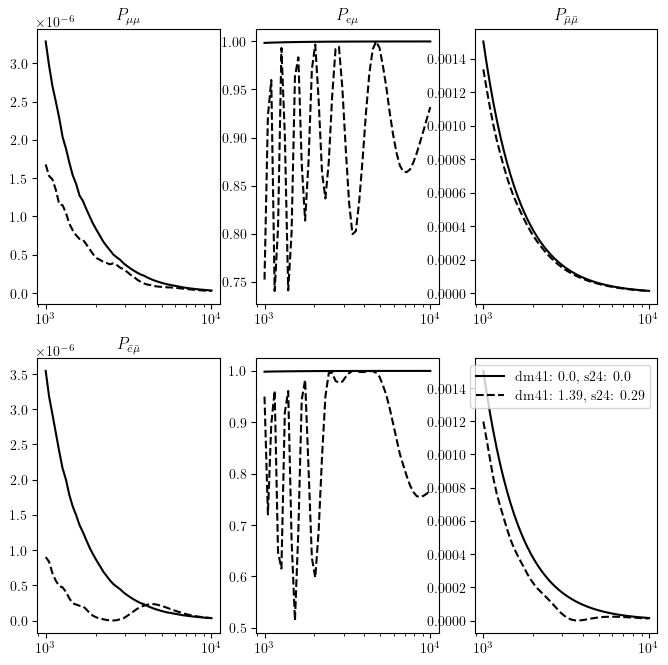

In [138]:
fig, ax = plt.subplots(2, 3, figsize=(8, 8))
ax = ax.flatten()
c = ["k"]
ls = ["solid", "dashed"]
for i, prob in enumerate(Pmm):
    ax[1].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )
for i, prob in enumerate(Pem):
    ax[0].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )
for i, prob in enumerate(Pamam):
    ax[4].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )
for i, prob in enumerate(Paeam):
    ax[3].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )

for i, prob in enumerate(Ptm):
    ax[2].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )
for i, prob in enumerate(Patam):
    ax[5].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )


ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[3].set_xscale("log")
ax[4].set_xscale("log")
ax[5].set_xscale("log")

ax[0].set_title("$P_{\mu\mu}$")
ax[1].set_title("$P_{e\mu}$")
ax[2].set_title("$P_{\\bar{\mu}\\bar{\mu}}$")
ax[3].set_title("$P_{\\bar{e}\\bar{\mu}}$")
plt.legend()

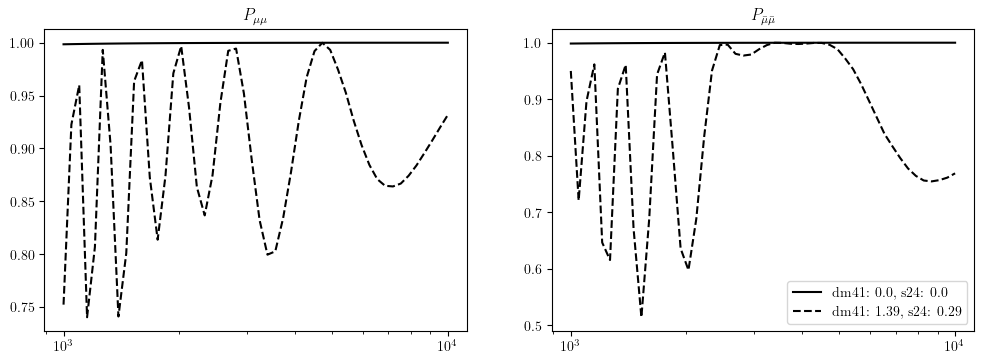

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.flatten()
c = ["k"]
ls = ["solid", "dashed"]
for i, prob in enumerate(Pmm):
    ax[0].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )
for i, prob in enumerate(Pamam):
    ax[1].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}',
        c=c[0],
        ls=ls[i],
    )


ax[0].set_xscale("log")
ax[1].set_xscale("log")

ax[0].set_title("$P_{\mu\mu}$")
ax[1].set_title("$P_{\\bar{\mu}\\bar{\mu}}$")
plt.legend()